In [1]:
import json
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import datetime
import math
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from pprint import pprint
from copy import deepcopy
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans, Birch, DBSCAN, SpectralClustering, OPTICS, AgglomerativeClustering, SpectralClustering
from keras.models import Model, Sequential
from keras.layers import Dense
from keras import layers, losses
from keras.utils import Progbar
from keras import backend as K
from MixedAutoencoder import Mixer, MixedAutoencoder, setRandom
seed = 12345
tf.random.set_seed(seed)
random.seed(seed)
setRandom(seed)
import json
# important variable
latent_dim = 3
num_sets = 4
base_path = "."
label = "demo4_3_test_1"
model_shape = [16]

In [2]:
data = pd.read_csv(f'{base_path}/data/16PF/data.csv', sep="\t")
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,P7,P8,P9,P10,age,gender,accuracy,country,source,elapsed
0,1,4,2,3,3,2,3,4,4,3,...,1,2,5,2,17,1,92,US,6,914
1,4,3,4,3,4,4,4,4,2,2,...,3,2,2,2,37,1,100,US,1,891
2,3,4,4,4,4,4,4,3,2,2,...,2,3,3,3,31,1,80,US,6,903
3,4,5,4,4,4,3,3,2,2,2,...,2,3,4,4,32,1,93,US,1,806
4,4,0,4,4,4,3,5,1,2,4,...,4,2,3,2,46,2,87,NZ,1,1826


In [3]:
def clean_data(data):
    #remove unwanted columns
    data.pop("age")
    data.pop("gender")
    data.pop("accuracy")
    data.pop("country")
    data.pop("source")
    data.pop("elapsed")
    data.pop("P10")

    #replace zeros with three, questions not answered replaced with average value
    return (data.loc[(data!=0).all(axis=1)]-3)
    #data.replace(0,3, inplace=True)

In [4]:
def split(data, split_labels = None):
    if not split_labels:
        labels = list(data.columns)
        random.shuffle(labels)
        split_labels = [labels[:50], labels[50:100], labels[100:150]]
    return [data[s] for s in split_labels]


In [5]:
def split_strat(data, num_sets = 3):
    # general idea is to split the data by question type letter(A), and then randomly select 1/3 of each letter to form
    # three mixed data sets

    # creating a dict of data frames for each letter in ASCII
    framesDict = {}
    for i in range(65, 81):
        framesDict[i] = pd.DataFrame()

    # running through data and sorting it into data frame based on letter
    for i in range(65, 81):
        for columns in data:
            if chr(i) in columns:
                framesDict[i][columns] = data[[columns]]
        

    # creating a dict containing three different data frames for eat data "set"

    setsDict = []
    #set_list = ['set1', 'set2', 'set3']
    set_list = list(range(num_sets))
    for s in set_list:
        setsDict.append(pd.DataFrame())


    # test code: works and prints the data set containing all A questions/answers
    #print (framesDict[65])

    # shuffles each dataframe so it's randomized when columns are later selected
    for i in range (65, 81):
        framesDict[i] = framesDict[i].sample(frac=1, axis=1)

    # idea here was to use iloc to select values in a range from variables a - b
    # and then increment a and b each time the "set" increments so that the data in each frame is split into the three sets
    # not working tho lol


    # calculate how many columns per "set" based on the amount of number of that letter question type
    # cols = len(framesDict[65].axes[1])
    # increment = int((cols - cols%3) /3) 


    # go through each data frame, resetting a and b each time
    remainders = pd.DataFrame()
    for i in range (65, 81):
        cols = len(framesDict[i].axes[1])
        increment = int((cols - cols%num_sets) /num_sets) 
        remainders = framesDict[i].iloc[:,(cols//num_sets) * num_sets:].join(remainders)
        a = 0
        b= increment 
        for s in set_list:   
            # print(setsDict[s])                      # go through each of the three sets
            # print(framesDict[i].iloc[:,a:b])
            
            setsDict[s] = framesDict[i].iloc[:,a:b].join(setsDict[s]  )     # and add on values from range a-b in the current letter/question dataframe
            # print(setsDict[s])  
            a += increment                                  # ^^^^ this line is probably the problem                        
            b += increment                                  # then increment a and b before moving on to next set



    cols = len(remainders.axes[1])
    increment = int((cols - cols%num_sets) /num_sets) 
    a = 0
    b= increment 
    for s in set_list:   
        # print(setsDict[s])                      # go through each of the three sets
        # print(framesDict[i].iloc[:,a:b])
        
        setsDict[s] = remainders.iloc[:,a:b].join(setsDict[s]  )     # and add on values from range a-b in the current letter/question dataframe
        # print(setsDict[s])  
        a += increment                                  # ^^^^ this line is probably the problem                        
        b += increment                                  # then increment a and b before moving on to next set



    return setsDict#['set1'], setsDict['set2'], setsDict['set3']]

In [6]:
def split_by_col_l(data, cols):
    new_data = []
    for col in cols:
        new_data.append(data[col])

    return new_data

In [7]:
def make_train_test(datas, split):
    train_datas = [d[:int(data.shape[0]*split)] for d in datas]
    test_datas = [d[int(data.shape[0]*split):] for d in datas]
    return train_datas, test_datas

In [8]:
data = clean_data(data)
#labels = list(data.columns)
#random.shuffle(labels)
#split_labels = [labels[:50], labels[50:100], labels[100:150]]
#print(data.columns[:])
#datas = split(data, split_labels = split_labels)
datas = split_strat(data, num_sets)
#cols = [['P4', 'O6', 'O10', 'N10', 'N8', 'M3', 'M9', 'P5', 'P1', 'O9', 'O3', 'N5', 'N6', 'M8', 'M2', 'L8', 'L6', 'K10', 'K1', 'J5', 'J9', 'I1', 'I7', 'H3', 'H8', 'G4', 'G3', 'F5', 'F10', 'E1', 'E8', 'D3', 'D10', 'C4', 'C9', 'B7', 'B6', 'B2', 'A1', 'A6'],['L5', 'L4', 'K3', 'K8', 'J3', 'J8', 'I4', 'P7', 'P3', 'O2', 'O5', 'N7', 'N3', 'M4', 'M10', 'L9', 'L2', 'K4', 'K9', 'J1', 'J10', 'I6', 'I8', 'H5', 'H6', 'G8', 'G1', 'F6', 'F1', 'E7', 'E2', 'D8', 'D2', 'C2', 'C3', 'B5', 'B12', 'B8', 'A3', 'A9'],['I10', 'H4', 'H10', 'G5', 'G6', 'F9', 'F4', 'P6', 'P2', 'O8', 'O4', 'N2', 'N1', 'M7', 'M6', 'L10', 'L3', 'K7', 'K6', 'J6', 'J7', 'I3', 'I2', 'H2', 'H1', 'G10', 'G7', 'F8', 'F3', 'E4', 'E5', 'D9', 'D5', 'C7', 'C10', 'B4', 'B1', 'B13', 'A2', 'A7'],['E3', 'E9', 'D7', 'D6', 'C8', 'C5', 'B3', 'P9', 'P8', 'O7', 'O1', 'N9', 'N4', 'M5', 'M1', 'L7', 'L1', 'K5', 'K2', 'J4', 'J2', 'I9', 'I5', 'H9', 'H7', 'G9', 'G2', 'F7', 'F2', 'E6', 'E10', 'D1', 'D4', 'C6', 'C1', 'B9', 'B11', 'B10', 'A8', 'A10']]
#datas = split_by_col_l(data, cols)
datas[0].head()

,P4,O7,O8,N7,N5,M1,M8,P6,P2,O10,...,E9,D2,D10,C3,C5,B10,B11,B6,A10,A5
0,1,-1,1,2,1,2,-2,2,2,1,...,0,0,0,1,-1,-1,-2,1,0,0
1,-1,-1,0,2,2,1,-2,-1,1,1,...,-1,-1,-2,0,-1,-1,1,1,-1,1
3,-1,2,1,2,2,1,-1,1,-1,1,...,-1,-1,0,0,0,0,0,2,-1,1
5,-1,-1,2,1,1,1,-1,0,1,1,...,-1,1,0,1,1,-1,-2,1,1,1
6,1,0,0,2,-1,1,-1,-1,-1,0,...,0,0,0,1,0,-1,-2,0,0,-1


In [9]:
#Input Output Interface

def interface(Qlist):
    f = open(f'{base_path}/data/16PF/16.PF.questions.csv')  
    print(f)
    #with open ("16.PF.questions.csv") as f:                          (what I was originally using in my own file)
    Qdict = {}
    for line in f.readlines():
        line = line.split(',',1)
        if line:
            Qdict[line[0]]=line[1]
    print(Qdict.keys())

    print("Please answer the following questions on a scale from 1-5, with 1 being strongly disagree, and 5 being strongly agree")

    new = {}
    # ask the question corresponding to the letter code, and add the user input to a dict
    for x in range (0, len(Qlist)):
        new[Qlist[x]] = int(input(Qdict[Qlist[x]].split("rated", 1)[0]))

    # add the dictionary with questions and answers to the dataframe
    responses = pd.DataFrame()
    responses = responses.append(new, ignore_index=True)

    #print(responses)
    return responses

In [10]:
def present(Qlist, ans):
    f = open(f'{base_path}/data/16PF/16.PF.questions.csv')  
    #print(f)
    #with open ("16.PF.questions.csv") as f:                          (what I was originally using in my own file)
    Qdict = {}
    for line in f.readlines():
        line = line.split(',',1)
        if line:
            Qdict[line[0]]=line[1]

    print(Qdict.keys())

    new = {}
    # ask the question corresponding to the letter code, and add the user input to a dict
    for x in range (0, len(Qlist)):
        print(Qdict[Qlist[x]].split("rated", 1)[0] + ": " + str(ans[0][x]))


In [11]:
Qlist = ['A1', 'A2', 'A3', 'A4']
# interface(Qlist)

In [12]:
datas[0].shape

(35466, 40)

In [13]:
int(datas[0].shape[0]*0.8)

28372

In [14]:
keys = {"a":0, "b":1, "c":2, "d":3}

In [15]:

train_datas = {k: datas[keys[k]][:int(data.shape[0]*0.8)] for k in keys}
train_datas["a"].shape

(28372, 40)

In [16]:
test_datas = {k: datas[keys[k]][int(data.shape[0]*0.8):] for k in keys}
test_datas["a"].shape

(7094, 40)

In [17]:
test_datas["b"].head()

,L5,L4,K1,K2,J4,J2,I2,P3,P7,O1,...,E7,D8,D3,C10,C9,B5,B2,B3,A1,A9
39236,0,1,-1,2,2,1,-1,0,0,1,...,-1,0,-1,0,-2,1,-1,2,2,-1
39237,-1,0,0,-1,1,1,0,0,1,1,...,-1,0,0,0,-1,1,1,1,1,-1
39238,2,1,-1,-1,0,1,-2,-1,-2,1,...,-2,-1,1,-1,0,2,1,-1,2,2
39239,0,1,-1,-2,0,1,-1,-1,-2,1,...,-2,-1,0,-1,-1,1,0,1,2,-2
39241,2,2,1,2,0,2,2,-1,-2,1,...,-1,-2,-2,0,1,2,2,2,2,1


In [18]:
train_datas["a"].head()

,P4,O7,O8,N7,N5,M1,M8,P6,P2,O10,...,E9,D2,D10,C3,C5,B10,B11,B6,A10,A5
0,1,-1,1,2,1,2,-2,2,2,1,...,0,0,0,1,-1,-1,-2,1,0,0
1,-1,-1,0,2,2,1,-2,-1,1,1,...,-1,-1,-2,0,-1,-1,1,1,-1,1
3,-1,2,1,2,2,1,-1,1,-1,1,...,-1,-1,0,0,0,0,0,2,-1,1
5,-1,-1,2,1,1,1,-1,0,1,1,...,-1,1,0,1,1,-1,-2,1,1,1
6,1,0,0,2,-1,1,-1,-1,-1,0,...,0,0,0,1,0,-1,-2,0,0,-1


In [19]:
train_datas["b"].head()

,L5,L4,K1,K2,J4,J2,I2,P3,P7,O1,...,E7,D8,D3,C10,C9,B5,B2,B3,A1,A9
0,2,0,-1,0,2,2,1,2,-2,1,...,-2,-1,2,-1,0,2,1,2,-2,1
1,-1,1,0,1,1,1,1,1,0,0,...,-1,-1,1,0,0,2,1,1,1,-1
3,1,0,0,0,2,2,-1,-1,-1,-1,...,-2,0,0,1,0,1,-1,1,1,-1
5,1,1,1,1,1,0,1,2,1,-1,...,-1,-1,2,-2,0,0,-2,1,0,-2
6,1,2,-2,-1,1,2,-1,1,1,1,...,-1,-1,0,0,-1,2,0,2,1,-2


In [20]:
train_datas["c"].head()

,I6,H7,H9,G7,G2,F1,F7,P5,P9,O3,...,E5,D5,D6,C1,C7,B7,B9,B8,A8,A7
0,1,0,-1,0,-2,-1,0,1,2,0,...,1,1,1,1,1,2,-2,1,1,0
1,-1,1,-2,0,1,0,1,0,-1,1,...,1,1,2,-2,1,0,0,-1,1,1
3,-1,0,-1,0,1,1,0,0,1,-1,...,1,-1,0,0,-1,1,0,1,-1,0
5,-2,-2,-2,1,1,-1,1,0,-1,1,...,1,1,0,-1,-1,0,-1,0,-2,2
6,-2,-1,-2,0,-2,0,-1,-1,0,1,...,-2,1,0,-2,2,2,-1,2,-1,1


In [21]:
input_dims = {k: (np.array(train_datas[k]).astype(float))[0].shape[0] for k in train_datas}

# Was getting a str() datatype error without this line below
#train_d = (np.array(data).astype(float))[:int((np.array(data).astype(float)).shape[0]*0.8)]

print(input_dims)

{'a': 40, 'b': 40, 'c': 40, 'd': 40}


Encoder

In [22]:
mixer = Mixer()

In [23]:
autoencoder_set = mixer.make_new({'a': model_shape, 'b': model_shape, 'c': model_shape, 'd': model_shape}, latent_dim, input_dims, ["a", "b", "c", "d"])

In [24]:
# new = Autoencoder_set(encoders, decoders, latent_dim, input_dims)
# new.copy(autoencoder_set)
# autoencoder_set = new

In [25]:
track_num = 243
print([train_datas[d].values[track_num] for d in train_datas])

[array([ 1,  1,  1,  1,  1,  2, -1, -1,  1,  1,  1,  1,  2, -1,  1,  0,  1,
        2,  2, -1,  1,  1, -1, -2,  1, -1,  2, -1,  1,  1, -1,  0, -1, -1,
        0, -1, -1,  1, -1,  2], dtype=int64), array([ 1,  1,  1, -2,  1,  1,  0,  0, -1,  2,  1,  2,  1,  1, -1,  1, -1,
        1,  1,  1,  1,  0,  2,  1, -1, -1,  1,  1, -1,  0, -1, -1, -1,  1,
        0,  1,  1,  1,  2, -2], dtype=int64), array([ 0, -2, -2, -1, -1,  0, -1, -1,  1,  1,  1,  1,  2, -1,  2,  0, -1,
       -2,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  0,  2,  1,  0,  1,
        1,  1, -1,  2,  1,  1], dtype=int64), array([ 0, -1,  0,  1, -2,  1,  1,  1,  0, -1, -1,  2, -1,  2,  0,  1,  1,
        2,  2, -1,  1,  1,  1,  2,  2,  1,  1,  0,  2,  1,  0,  0,  2, -1,
        1,  2,  1, -1,  1,  2], dtype=int64)]


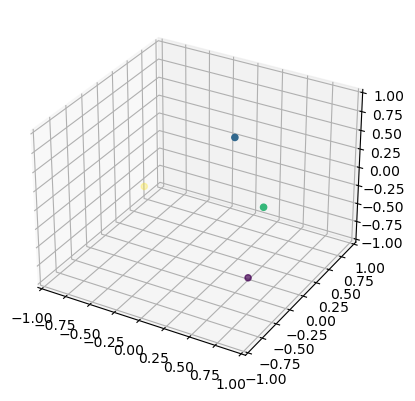

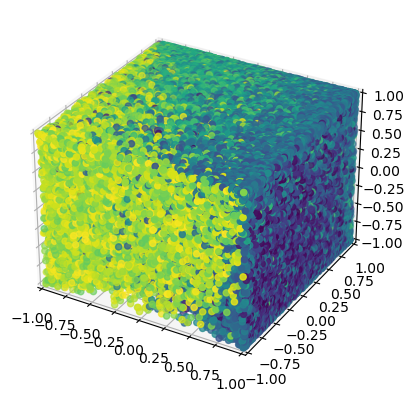

epoch 0
444/444 [==============================] - 7s 6ms/step - loss: 1.1662 - val_loss: 0.9472 - accuracy: 0.3421


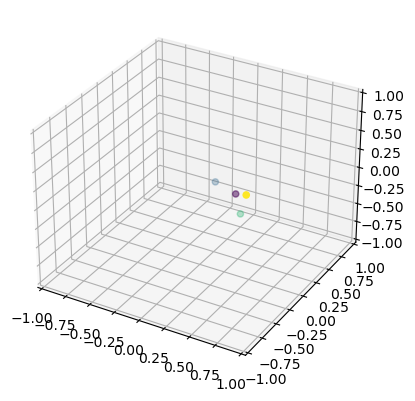

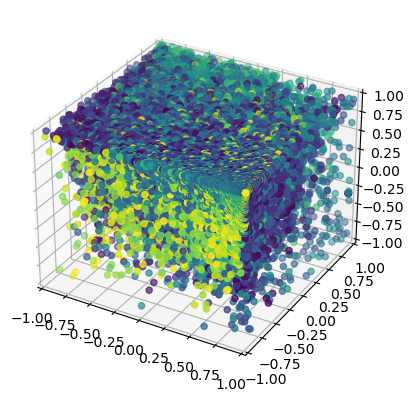

epoch 1
444/444 [==============================] - 5s 6ms/step - loss: 1.0948 - val_loss: 0.9074 - accuracy: 0.3745


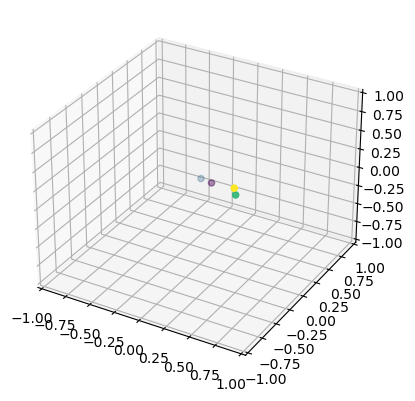

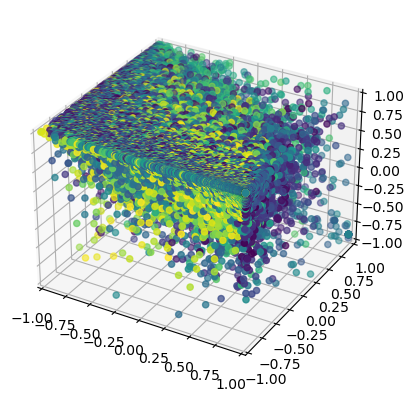

epoch 2
444/444 [==============================] - 5s 6ms/step - loss: 1.0744 - val_loss: 0.8956 - accuracy: 0.3772


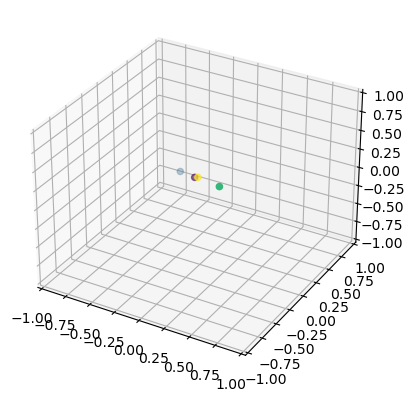

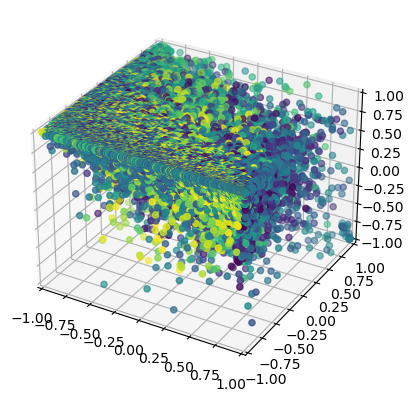

epoch 3


KeyboardInterrupt: 

In [26]:
#ignore = [(a, b) for a in range(num_sets) for b in range(num_sets) if (a != (b+1)%num_sets)]
#ignore2 = []#[(a, a) for a in range(num_sets)]
#autoencoder_set.train_set_old(train_datas, 5, batch_size = 64, ignore_pairs = ignore, track_num = track_num)
settings = {
    "training": [["$all", "$all", True, True]],#[[[k1], [k2 for k2 in keys if k1 != k2], True, True] for k1 in keys],
    #"encoder_proximity_training": [["$all", True]],
    "plot": [True, 3, [0, 1, 2]]
    }
autoencoder_set.train_set(train_datas, 25, autoencoder_set.make_train_config(settings = settings), batch_size = 64, track_num = track_num)

In [ ]:
cold = {x: list(train_datas[x]) for x in train_datas}
mixer.save_to_label(autoencoder_set, extra = {"columns" : cold}, label = label)
#autoencoder_set.save_models(label = label, extra = {"columns" : cold})

INFO:tensorflow:Assets written to: ./Models/model_demo4_3_t20/encoder_a\assets
INFO:tensorflow:Assets written to: ./Models/model_demo4_3_t20/decoder_a\assets
INFO:tensorflow:Assets written to: ./Models/model_demo4_3_t20/encoder_b\assets
INFO:tensorflow:Assets written to: ./Models/model_demo4_3_t20/decoder_b\assets
INFO:tensorflow:Assets written to: ./Models/model_demo4_3_t20/encoder_c\assets
INFO:tensorflow:Assets written to: ./Models/model_demo4_3_t20/decoder_c\assets
INFO:tensorflow:Assets written to: ./Models/model_demo4_3_t20/encoder_d\assets
INFO:tensorflow:Assets written to: ./Models/model_demo4_3_t20/decoder_d\assets


In [ ]:
# extra = autoencoder_set.load_models(label = label)
# train_datas, test_datas = make_train_test(split_by_col_l(data, [list(extra["columns"][str(x)]) for x in range(num_sets)]), 0.8)

In [ ]:
autoencoder_set.eval_set(test_datas)

('a', 'a')
222/222 [==============================] - 0s 618us/step - loss: 1.0635
compared to average: 1.4528545249506626
('a', 'b')
222/222 [==============================] - 0s 574us/step - loss: 1.8200
compared to average: 1.5825697772765717
('a', 'c')
222/222 [==============================] - 0s 566us/step - loss: 1.9446
compared to average: 1.5384797011559064
('a', 'd')
222/222 [==============================] - 0s 558us/step - loss: 2.0001
compared to average: 1.5421729630673808
('b', 'a')
222/222 [==============================] - 0s 559us/step - loss: 1.6521
compared to average: 1.4528545249506626
('b', 'b')
222/222 [==============================] - 0s 753us/step - loss: 1.2468
compared to average: 1.5825697772765717
('b', 'c')
222/222 [==============================] - 0s 614us/step - loss: 1.5358
compared to average: 1.5384797011559064
('b', 'd')
222/222 [==============================] - 0s 557us/step - loss: 1.6049
compared to average: 1.5421729630673808
('c', 'a')
222/2

In [ ]:
autoencoder_set.show_accuracy(test_datas)

calculating for ('a', 'a')
accuracy of ('a', 'a') is: 0.3574182391166687
accuracy with error is: 0.507345974445343
calculating for ('a', 'b')
accuracy of ('a', 'b') is: 0.2552791237831116
accuracy with error is: 0.3763497471809387
calculating for ('a', 'c')
accuracy of ('a', 'c') is: 0.24580983817577362
accuracy with error is: 0.36374929547309875
calculating for ('a', 'd')
accuracy of ('a', 'd') is: 0.23790879547595978
accuracy with error is: 0.3576050400733948
calculating for ('b', 'a')
accuracy of ('b', 'a') is: 0.2631942629814148
accuracy with error is: 0.3986608386039734
calculating for ('b', 'b')
accuracy of ('b', 'b') is: 0.30705174803733826
accuracy with error is: 0.4521867334842682
calculating for ('b', 'c')
accuracy of ('b', 'c') is: 0.28019100427627563
accuracy with error is: 0.41755181550979614
calculating for ('b', 'd')
accuracy of ('b', 'd') is: 0.26164716482162476
accuracy with error is: 0.397897869348526
calculating for ('c', 'a')
accuracy of ('c', 'a') is: 0.23660135269

In [ ]:
#autoencoder_set.show_error_distribution(test_datas)

In [ ]:
autoencoder_set.show_error_accuracy(test_datas)

To achive 0.3 accuracy, an error of +-0.5859375 is required.
To achive 0.35 accuracy, an error of +-0.6640625 is required.
To achive 0.4 accuracy, an error of +-0.7421875 is required.
To achive 0.45 accuracy, an error of +-0.859375 is required.
To achive 0.5 accuracy, an error of +-0.9375 is required.
To achive 0.55 accuracy, an error of +-1.0546875 is required.
To achive 0.6 accuracy, an error of +-1.1328125 is required.
To achive 0.65 accuracy, an error of +-1.25 is required.
To achive 0.7 accuracy, an error of +-1.3671875 is required.
To achive 0.75 accuracy, an error of +-1.5234375 is required.
To achive 0.8 accuracy, an error of +-1.6796875 is required.
To achive 0.85 accuracy, an error of +-1.875 is required.
To achive 0.9 accuracy, an error of +-2.109375 is required.
To achive 0.95 accuracy, an error of +-2.4609375 is required.


In [ ]:
autoencoder_set.show_binary_accuracy(test_datas)

binary accuracy is: 0.5439972524239857


In [ ]:
scatter_train = autoencoder_set.plot_to_latent_space([t.values for t in train_datas])
scatter_test = autoencoder_set.plot_to_latent_space([t.values for t in test_datas])

AttributeError: 'str' object has no attribute 'values'

In [ ]:
if latent_dim == 2:
    mapqL = autoencoder_set.map_latent_space(100)

train scatter

In [ ]:
autoencoder_set.make_scatter(scatter_train[0], 3, [0, 1, 2])
autoencoder_set.make_scatter(scatter_train[1], 3, [0, 1, 2])
autoencoder_set.make_scatter(scatter_train[2], 3, [0, 1, 2])
autoencoder_set.make_scatter(np.concatenate(scatter_train), 3, [0, 1, 2])

In [ ]:
sub = 243

item = np.concatenate((scatter_train[0, sub:sub+1],scatter_train[1, sub:sub+1],scatter_train[2, sub:sub+1]))
print(item)
autoencoder_set.make_scatter(item, 3, [0, 1, 2])

[[ 0.25720188 -0.7258757  -0.1411017   0.46623987 -0.5195671   0.23425995
  -0.4942127  -0.35063037]
 [ 0.5067651  -0.6875723   0.25912422  0.00251117 -0.41635072  0.5625128
   0.3854703  -0.04527591]
 [ 0.20973393 -0.26568392 -0.6577896   0.32911214 -0.5893648   0.32843676
   0.31097502  0.0995928 ]]


test scatter

In [ ]:
autoencoder_set.make_scatter(scatter_test[0], 3, [0, 1, 2])
autoencoder_set.make_scatter(scatter_test[1], 3, [0, 1, 2])
autoencoder_set.make_scatter(scatter_test[2], 3, [0, 1, 2])
autoencoder_set.make_scatter(np.concatenate(scatter_test), 3, [0, 1, 2])

In [ ]:
sub = 432

item = np.concatenate(([s[sub:sub+1] for s in scatter_test]))
print(item)
autoencoder_set.make_scatter(item, 3, [0, 1, 2])

[[-5.3650385e-01  4.7631079e-01 -3.8372540e-01 -8.1723875e-01
  -3.8606954e-01  3.4444812e-01 -2.1187304e-01  4.2352036e-01]
 [ 3.1721652e-01  2.1990475e-01 -4.8257226e-01 -8.4246957e-01
  -1.2395017e-01 -2.4727473e-01 -5.1807791e-01 -2.7105546e-01]
 [ 6.4495939e-04  4.9743021e-01 -3.4459484e-01 -7.5711590e-01
  -3.5914382e-01  4.0314129e-01 -7.7400041e-01  6.4767647e-01]
 [ 9.3950212e-02  5.8507079e-01 -6.7072028e-01 -9.1885638e-01
  -1.0849325e-01  1.7994688e-01 -7.4494064e-01  2.5159535e-01]]


map

In [ ]:
if latent_dim == 2:
    
    for i, dim in enumerate(input_dims):
        print(i, dim)
        for qi in range(dim):
            plt.imshow(mapqL[i][qi])
            plt.colorbar()
            plt.pause(0.01)
    plt.show()

Test/demo?

In [ ]:
# e = 0
# Qlist = list(train_datas[e])
# print(Qlist)
# resp = interface(Qlist)[list(train_datas[e])]

In [ ]:
# enc = autoencoder_set.make_encoding(resp, e)
# plt.imshow([[enc[0]]])

In [ ]:
# d = 1
# pred = autoencoder_set.make_prediction(resp, e, d)
# present(list(train_datas[d]), pred)